# Gender Classification from audio files

I will put in the notebook (as text) also the steps to download and unzip the dataset:
<ul>
  <li>!wget https://www.openslr.org/resources/12/dev-clean.tar.gz</li>
  <li>!tar -xzf dev-clean.tar.gz</li>
</ul>
I usually do a first analysis by exploring the dataset by hand. In this case my understanding are:
<ol>
  <li>One directory for each reader, each reader has an id.</li>
  <li>In each directory there are some audio files (.flac) related to that specific reader</li>
  <li>For each reader it's available a set of informations: gender, how many minutes he/she has spoken and so on</li>
</ol>
    The first thing i want to do is load the speakers file. In order to do so i have to do some pre-processing: firstly the file has some starting lines with initial character ";", i dont want to take those rows into account during the dataset creation. Secondly ( i want to load the dataset as a CSV with "|" as separation character) there is a row in the file,the number 60, which has a name value of "|CBW|Simon", i want to get rid of those "|" in the name or the parsing will not be possible.

In [1]:
#Base variables: the root folder is the name of the dataset's root folder
#Speakers file is the filename associated to speakers and their details
root_folder = "LibriSpeech"
speakers_file = "SPEAKERS.TXT"
#Create the path-string "LibriSpeech/SPEAKERS.TXT" in order to open the file
speakers = open("/".join([root_folder, speakers_file]))

In [2]:
#Create the list of rows which are considered not informative for the purpose
exclude_rows = [i for i, line in enumerate(speakers) if line.startswith(';')]
print(exclude_rows)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [3]:
import pandas as pd
import re
from io import StringIO

In [4]:
#To get rid off |CBW|Simon and get (CBW)Simon it's possible to use a regexp and substitute in the file
speakers = open("/".join([root_folder, speakers_file]))
result = re.sub("\|CBW\|", "(CBW)", speakers.read())

In [5]:
#Create columns names for the datase and read the dataset
ds_columns_names = ["ID", "SEX", "SUBSET", "MINUTES", "NAME"]
speakers_df = pd.read_csv(StringIO(result), sep='|', skiprows= exclude_rows, names=ds_columns_names)

The next step in my mind was to filter on the subset column to keep only the rows with a value related to my dataset: dev-clean. In order to do it it's better to strip all the strings in the database to avoid errors like " dev-clean " != "dev-clean" due to the blank spaces.

In [6]:
#Consider only the non-numeric values in the dataframe
speakers_obj = speakers_df.select_dtypes(['object'])
#To replace the columns we have to know which columns are object-typed and then assign them the 
#strip-ed values created with the strip method of series
speakers_df[speakers_obj.columns] = speakers_obj.apply(lambda x: x.str.strip())
#Aplly the filter
speakers_df = speakers_df[(speakers_df['SUBSET'] == "dev-clean")]

In [7]:
#We check for the dimensions of the dataframe. I expect to have 40 rows (number of folders in the dataset).
speakers_df.shape

(40, 5)

Until all the steps are classical pre-processing steps. I want now to start extracting some features from audios and analyze them in order to avoid the **garbage-in garabage-out** problem. After some researches i decided to use librosa to handle audio files.

In [8]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from typing import List

In the next steps i will focus on point 2 and 3 of part 1. I didn't knew anything about the MFCC features so i will probably move in a "wrong way". I made some researches and i found that MFCCs are a set of features which describe the whole shape of the audio signal. I want first of all to create a function which, given an id, generates a list of audio files related to that specific id.

In [9]:
#define a variable for the dataset folder
dataset_name = "dev-clean"
#this function gets an ids an return a list of strings that are all the audios provided for that specific id
def get_audio_files_path(ids : int) -> List[str]:
    id_path = "/".join([root_folder, dataset_name, str(ids)])
    chapter_path = os.listdir(id_path)
    audio_path = "/".join([id_path, chapter_path[0]])
    audio_files = [file.name for file in os.scandir(audio_path) if file.name.endswith(".flac")]
    return ["/".join([audio_path,file]) for file in audio_files]

The idea for the previous function is to pass an id, get all the audio files, and for all the audio files load with librosa and extract the mfcc. Before diving into this process i made a simple example to try to understand what kind of shape a mfcc feature has:

In [10]:
#Get an list of audios related to a fixed id i choosed from the dataset
#in particular 84 is the id of a female speaker
trial_female_audios = get_audio_files_path(84)
y_female_trial , sr_female_trial = librosa.load(trial_female_audios[0])

I also tried to understand the shape of y and sr. My understanding were:
<ol>
    <li> sr is the sampling rate
    <li> y is the amplitude related to the track
<ol>
For the second reason i can plot the audio wave using matplotlib:

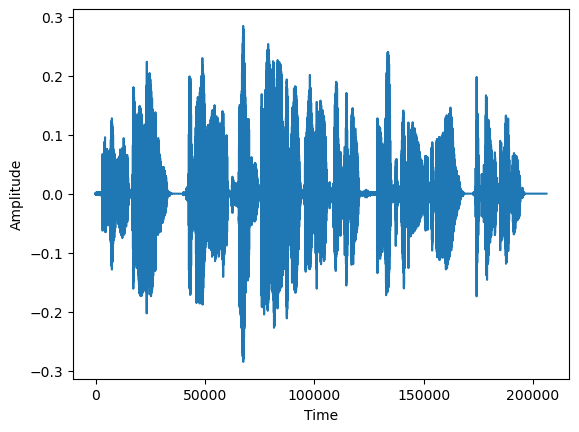

In [11]:
#plot the amplitude for the female speaker
plt.plot(y_female_trial)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

All the files provided in the dataset are .flac. I searched for the typical sampling rate for a .flac and i found that there is a standard sampling rate: 22050 Hz, also librosa.load() method uses a sample rate of 22050 Hz. I will then assume that all the files were deploied using that specific sampling rate. It's fairly easy extract the mfcc features:

In [12]:
#compute the mfccs for the first spaker and get the shape
mfccs_female_trial = librosa.feature.mfcc(y=y_female_trial, sr=sr_female_trial)
mfccs_female_trial.shape

(20, 403)

Using the method in librosa for extracting the mfccs i obtain a matrix of 20 rows and 403 columns. I assume that the 20 rows are the mfcc features, so i will work on them. I try to plot some of them to have a look at the ranges:

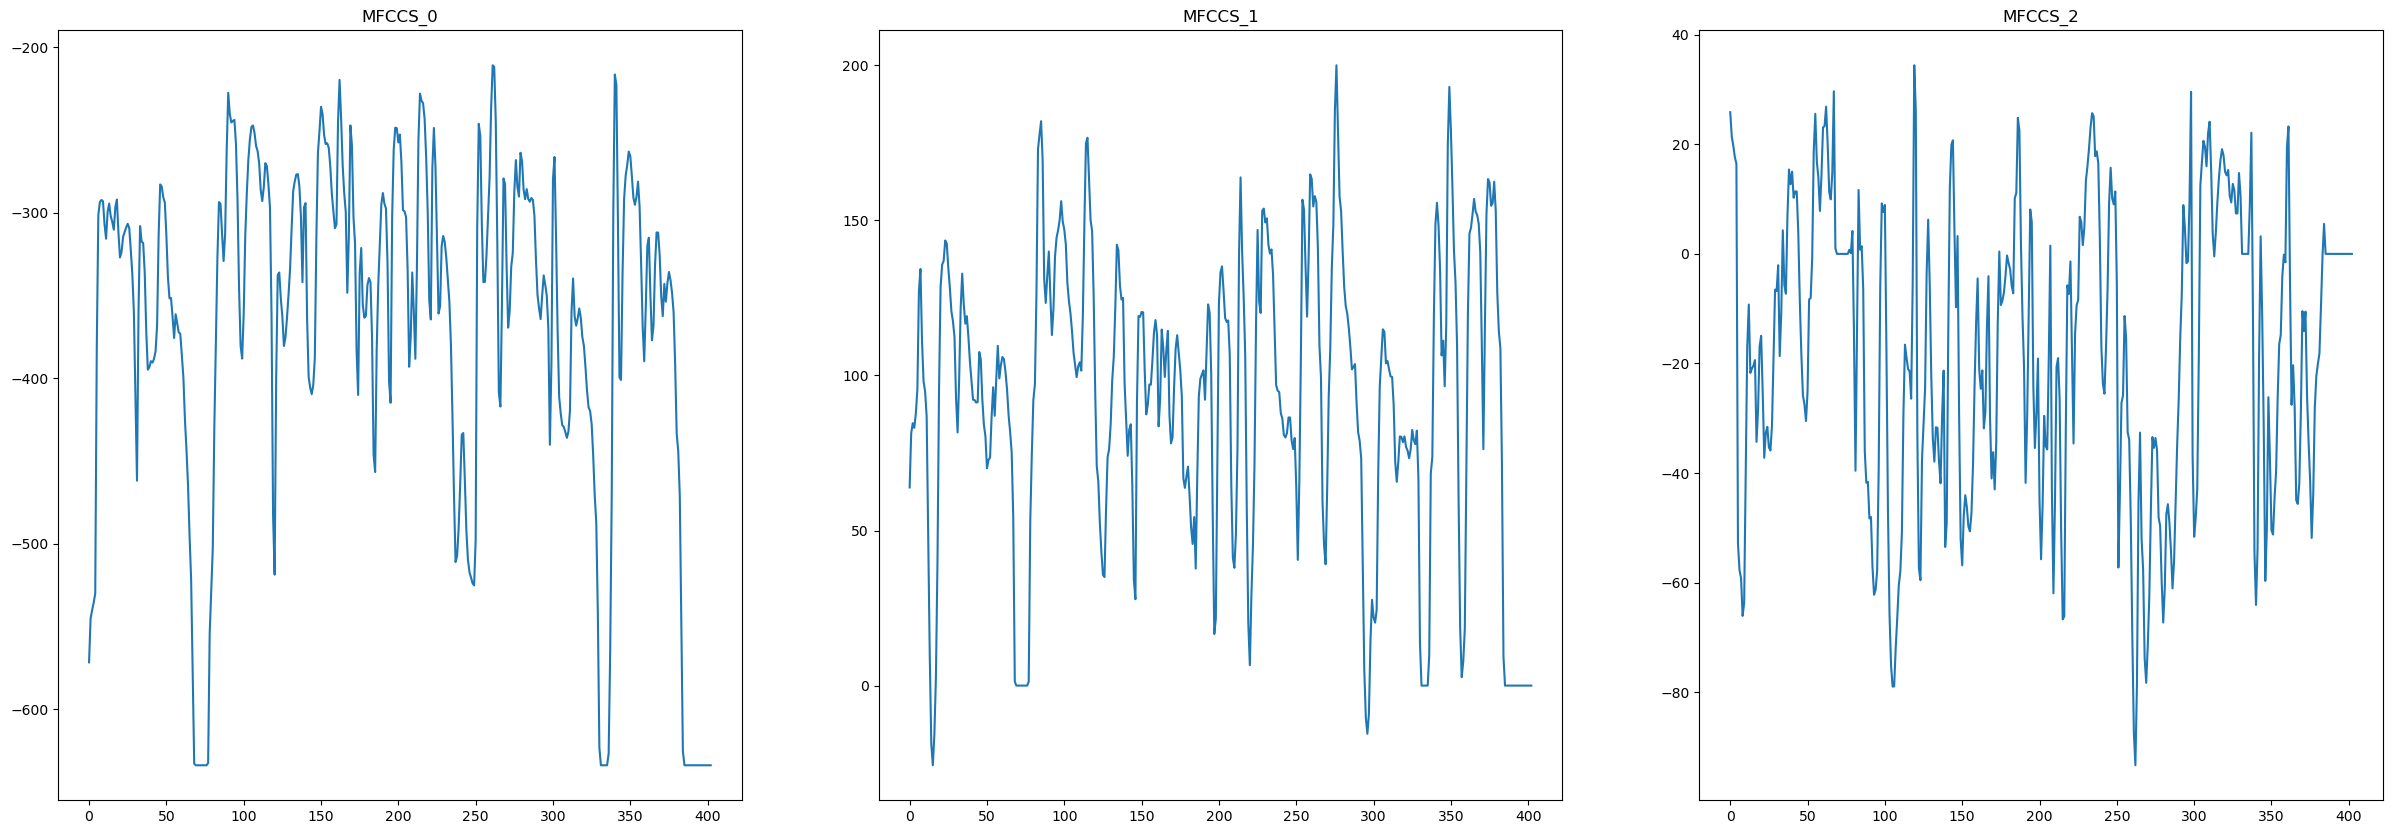

In [13]:
num_rows_trial = 1
num_columns_trial = 3
mfcc_index_trial = 0
fig_trial, axs_trial = plt.subplots(num_rows_trial, num_columns_trial, figsize=(30, 10))
for rows in range(num_rows_trial):
    for cls in range(num_columns_trial):
        axs_trial[cls].set_title(f'MFCCS_{mfcc_index_trial}')
        axs_trial[cls].plot(mfccs_female_trial[mfcc_index_trial])
        mfcc_index_trial += 1

So every mfcc feature is a wave, and if i have understood well the combination of all this features gives the shape of the original sound. Probably there will be a particular mfccs which is particularly different for most men and female speakers. I assume that will be a feature associated for example with the speaker's pitch: in general i would assume that men's pitch is lower than womens' one.

In [14]:
#same as above for a male speaker
trial_male_audios = get_audio_files_path(174)
y_male_trial , sr_male_trial = librosa.load(trial_male_audios[2])
mfccs_male_trial = librosa.feature.mfcc(y=y_male_trial, sr=sr_male_trial)

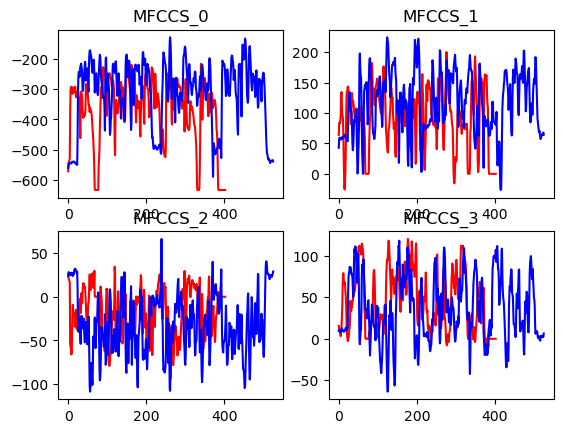

In [15]:
num_rows_trial = 2
num_columns_trial = 2
mfcc_index_trial = 0
fig_trial, axs_trial = plt.subplots(num_rows_trial, num_columns_trial)
for rows in range(num_rows_trial):
    for cls in range(num_columns_trial):
        axs_trial[rows][cls].set_title(f'MFCCS_{mfcc_index_trial}')
        axs_trial[rows][cls].plot(mfccs_female_trial[mfcc_index_trial], c='red')
        axs_trial[rows][cls].plot(mfccs_male_trial[mfcc_index_trial], c='blue')
        mfcc_index_trial += 1

The problem is **maybe** with the lengths of the audio file. For this reason i checked for the shortest track in the dataset:

In [16]:
#for each audio i get the duration values and append to an array
length_values = []
for ids in speakers_df['ID']:
    audio_list = get_audio_files_path(ids)
    for audio in audio_list:
        y , sr = librosa.load(audio)
        length_values.append(y.shape[0])
#get the shortest duration
shortest_time_duration = min(length_values)

In [17]:
#normalzie the lenght to the shortest one, re-extract mfccs
normalized_male_trial = librosa.util.fix_length(y_male_trial, size=shortest_time_duration)
normalized_female_trial = librosa.util.fix_length(y_female_trial, size=shortest_time_duration)
mfccs_male_trial = librosa.feature.mfcc(y=normalized_male_trial, sr=sr_male_trial)
mfccs_female_trial = librosa.feature.mfcc(y=normalized_female_trial, sr=sr_female_trial)
mfccs_male_trial.shape, mfccs_female_trial.shape

((20, 63), (20, 63))

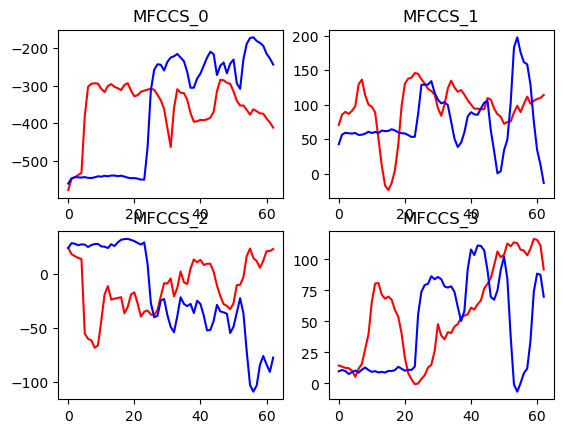

In [18]:
num_rows_trial = 2
num_columns_trial = 2
mfcc_index_trial = 0
fig_trial, axs_trial = plt.subplots(num_rows_trial, num_columns_trial)
for rows in range(num_rows_trial):
    for cls in range(num_columns_trial):
        axs_trial[rows][cls].set_title(f'MFCCS_{mfcc_index_trial}')
        axs_trial[rows][cls].plot(mfccs_female_trial[mfcc_index_trial], c='red')
        axs_trial[rows][cls].plot(mfccs_male_trial[mfcc_index_trial], c='blue')
        mfcc_index_trial += 1

In this case the information loss was too high. I decided to switch to the mean length.

In [19]:
length_values = []
for ids in speakers_df['ID']:
    audio_list = get_audio_files_path(ids)
    for audio in audio_list:
        y , sr = librosa.load(audio)
        length_values.append(y.shape[0])
#get the mean duration
mean_time_duration = int(np.mean(length_values))

In [20]:
normalized_male_trial = librosa.util.fix_length(y_male_trial, size=mean_time_duration, mode='mean')
normalized_female_trial = librosa.util.fix_length(y_female_trial, size=mean_time_duration, mode='edge')
mfccs_male_trial = librosa.feature.mfcc(y=normalized_male_trial, sr=sr_male_trial)
mfccs_female_trial = librosa.feature.mfcc(y=normalized_female_trial, sr=sr_female_trial)
mfccs_male_trial.shape, mfccs_female_trial.shape

((20, 324), (20, 324))

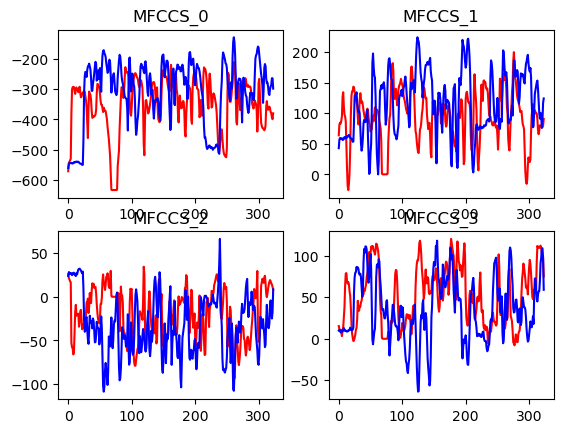

In [21]:
num_rows_trial = 2
num_columns_trial = 2
mfcc_index_trial = 0
fig_trial, axs_trial = plt.subplots(num_rows_trial, num_columns_trial)
for rows in range(num_rows_trial):
    for cls in range(num_columns_trial):
        axs_trial[rows][cls].set_title(f'MFCCS_{mfcc_index_trial}')
        axs_trial[rows][cls].plot(mfccs_female_trial[mfcc_index_trial], c='red')
        axs_trial[rows][cls].plot(mfccs_male_trial[mfcc_index_trial], c='blue')
        mfcc_index_trial += 1

The new duration was appropriate to me.
Before proceeding with the next steps i must describe an intermediate step which i have done but it's not reported due to the level of "naiveness" which i put. My goal was to normalize the audio tracks so i told myself: we can use the minmax normalizer which is already included in sklearn library. MinMax is know to not be resilient to outlier presence so i wanted to delete all the outliers and then normalize. I computed the mean and the std deviation for all the features and i removed all tracks with values not included in mean()+/-3\*std and after this step i normalized with MinMax, the result was awful: all the distributions were stacked one above the other and i had completely lost all the informations about the audio tracks. I assumed that standard normalizer are not effective on this kind of data. After experiencing this on my skin i searched for a normalizer in librosa and i found a normalizer implemented by the library itself, so i decided to use it. Indeed for each audio file i used the normalizer to get the vector normalization on each mfccs component. In the following example i'm assuming that the choice i made before are good choices (surely not), i'm completely aware of the fact that changing only one of those could completely nullify all the results i will find. This is completely imputable to my actual knowledge about audio file classification.

In [22]:
#create a list into which put the mfccs values + mean of the values + id + sex for each of the 20 values.
mfccs_values = []
for ids in speakers_df['ID']:
    audio_list = get_audio_files_path(ids)
    for audio in audio_list:
        y , sr = librosa.load(audio)
        #fix the length of the audio file
        y = librosa.util.fix_length(y, size=mean_time_duration, mode='edge')
        #normalize all the features
        mfccs = librosa.util.normalize(librosa.feature.mfcc(y=y, sr=sr), axis=1)
        speaker_sex = speakers_df.loc[speakers_df['ID'] == ids, 'SEX'].iloc[0]
        base_series = [ids, speaker_sex, audio]
        for i in range(mfccs.shape[0]):
            base_series.append(mfccs[i])
            base_series.append(mfccs[i].mean())
        mfccs_values.append(base_series)

In [23]:
#create the dataframe with all the desired properties
mfccs_properties = [f"MFCC_{i},MFCC_{i}_MEAN" for i in range(20)]
mfccs_df_columns = ["ID", "SEX", "AUDIO"] + [prop for prop_list in mfccs_properties \
                                             for prop in prop_list.split(",")]
mfccs_df = pd.DataFrame(mfccs_values, columns=mfccs_df_columns)
mfccs_df.head(3)

,ID,SEX,AUDIO,MFCC_0,MFCC_0_MEAN,MFCC_1,MFCC_1_MEAN,MFCC_2,MFCC_2_MEAN,MFCC_3,...,MFCC_15,MFCC_15_MEAN,MFCC_16,MFCC_16_MEAN,MFCC_17,MFCC_17_MEAN,MFCC_18,MFCC_18_MEAN,MFCC_19,MFCC_19_MEAN
0,84,F,LibriSpeech/dev-clean/84/121550/84-121550-0026...,"[-0.9018611, -0.85995024, -0.8520502, -0.84488...",-0.552348,"[0.31942815, 0.4066178, 0.42306694, 0.41546494...",0.475998,"[0.27704757, 0.22916506, 0.21119052, 0.1888693...",-0.197814,"[0.12796147, 0.097497575, 0.09031849, 0.084052...",...,"[0.1357135, 0.078565806, -0.011635951, -0.1089...",-0.381600,"[0.048841204, 0.08400083, -0.095100634, -0.178...",-0.095538,"[-0.07232095, 0.019918647, -0.14694028, -0.280...",-0.362465,"[0.24506837, 0.3083263, 0.1382639, -0.06785281...",-0.256912,"[0.32380953, 0.41409752, 0.33017188, 0.1986901...",-0.293155
1,84,F,LibriSpeech/dev-clean/84/121550/84-121550-0033...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",-0.534423,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.429379,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.158695,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.396755,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.007960,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.386457,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.143958,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.229451
2,84,F,LibriSpeech/dev-clean/84/121550/84-121550-0020...,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",-0.615495,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.484974,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.153966,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.319321,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002623,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.275295,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.203142,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.285802


At this point i proceeded with the examination of the boxplots for each mfcc index. I'm interested in checking if any outlier exists (and they do exist) and i'm also intereseted in the range: i expect it to be pretty much the same for all box-plots, the reason is that i have normalized the values. From the boxplots i can also understand if some of the features i'm looking at is skewed. In this case all the boxes seem pretty much in the center of the whiskers, so i expect that the histograms of all the values will be middle-centered.

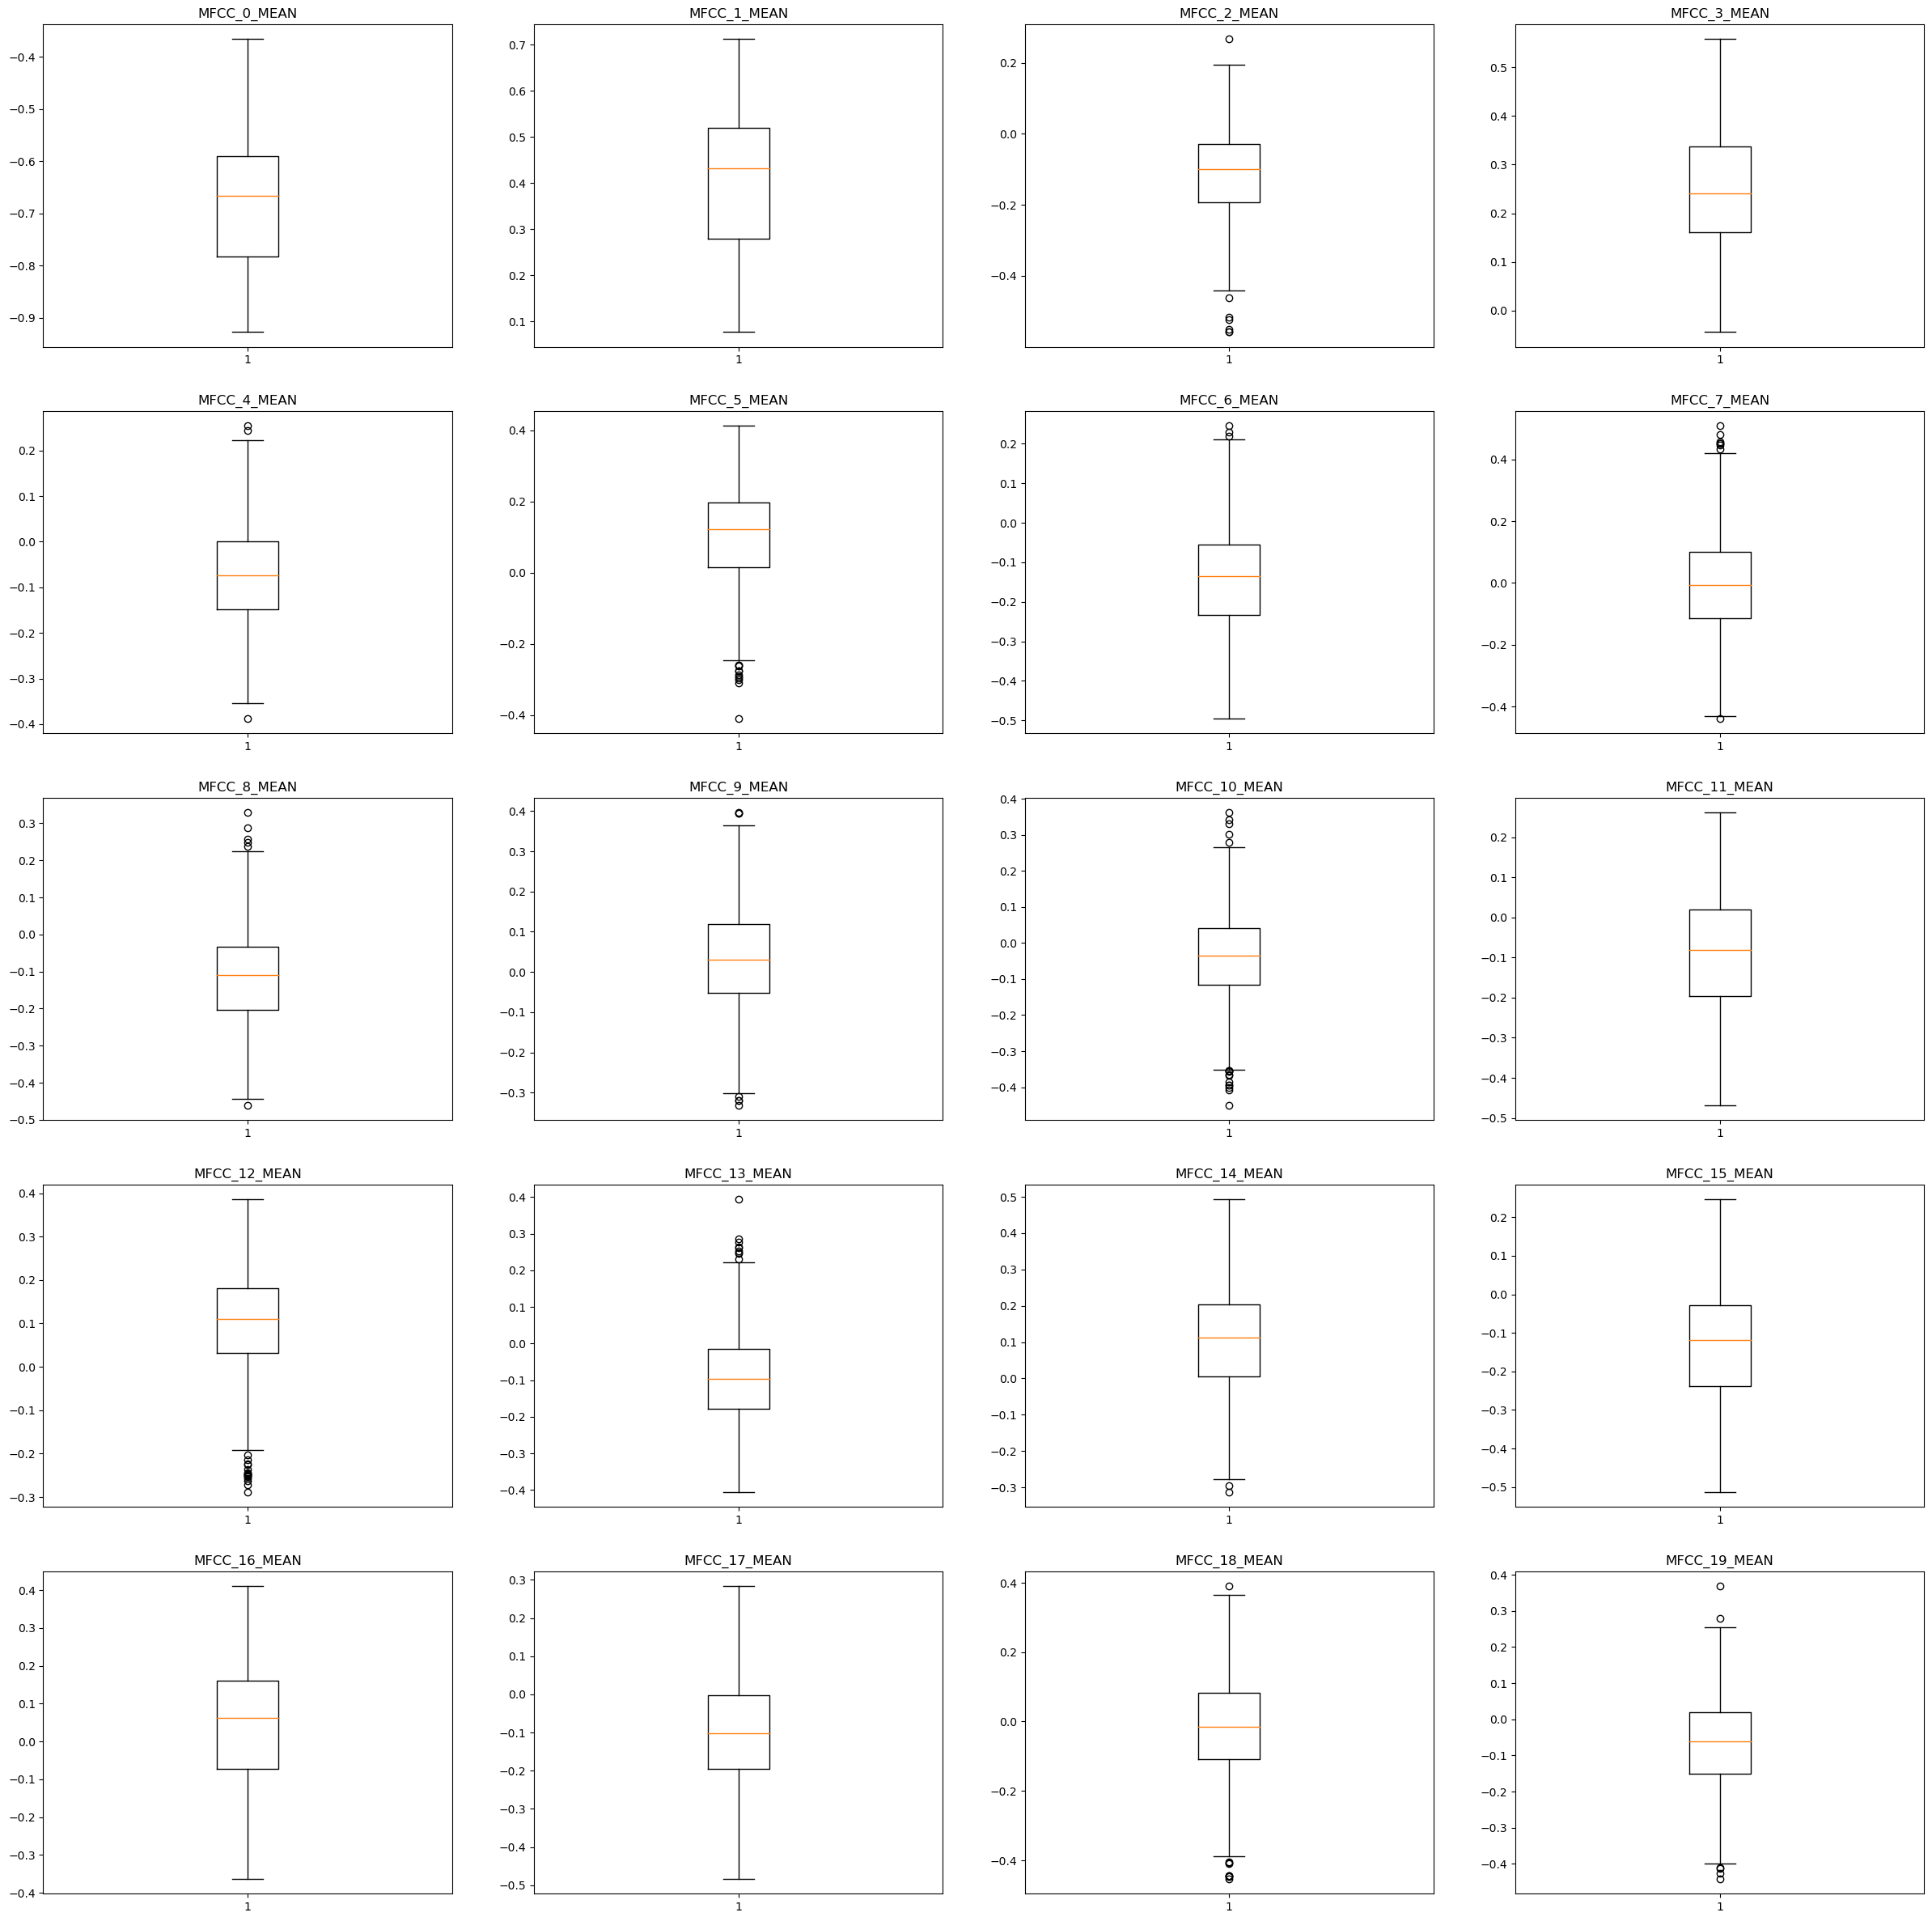

In [24]:
num_rows = 5
num_columns = 4
mfcc_index = 0
fig, axs = plt.subplots(num_rows, num_columns, figsize=(30, 30))
for row in range(num_rows):
    for cls in range(num_columns):
        df_mean = mfccs_df[f"MFCC_{mfcc_index}_MEAN"]
        axs[row][cls].boxplot(df_mean)
        axs[row][cls].set_title(f"MFCC_{mfcc_index}_MEAN")
        mfcc_index+=1

Even if with the boxplots i was able to visually find some outliers, now i'm interesetd in removing them: having outliers in the dataset can drive the classification in a bad way. The way in matplotlib checks for outliers is different then the one i will use. I choosed to use the 95% empirical rule because:
<ol>
    <li> I have normalized the distribution
    <li> All the distributions seem normal-like distribution
</ol>
In the following code snippet i will just take the mean for each feature and compute the standard criterium for the 95% rule. After obtaining the lower bound and the upper bound i just checked for all the audios in which the mean was ubove the upper bound or below the lowe bound.

In [25]:
audio_outlier_set = set()
for i in range(20):
    up_bound = mfccs_df[f"MFCC_{i}_MEAN"].mean() + 3*mfccs_df[f"MFCC_{i}_MEAN"].std()
    low_bound = mfccs_df[f"MFCC_{i}_MEAN"].mean() - 3*mfccs_df[f"MFCC_{i}_MEAN"].std()
    mfccs_outliers = mfccs_df[(mfccs_df[f"MFCC_{i}_MEAN"] >= up_bound) | \
                                    (mfccs_df[f"MFCC_{i}_MEAN"] <= low_bound)]
    for audio in mfccs_outliers["AUDIO"].values:
        audio_outlier_set.add(audio)

In [26]:
mfccs_df = mfccs_df[~mfccs_df['AUDIO'].isin(audio_outlier_set)]

After the outlier removing phase i decided to try to find some hints about the differences between the mean of the mfccs for the male and the female speakers. In order to do this analysis i decided to graph all the hist plot and compute the overlapping area between the male distribution and the female distribution. Once got the areas my idea was to sort them and keep the first x features, so the most separable one. I first setted up the same range for each histogram and the same number of bins (i choosed 100 emplirically: if too low the overlap area was too approximated, if too high the computation would have become too complex with not so much increase for the result's precision).

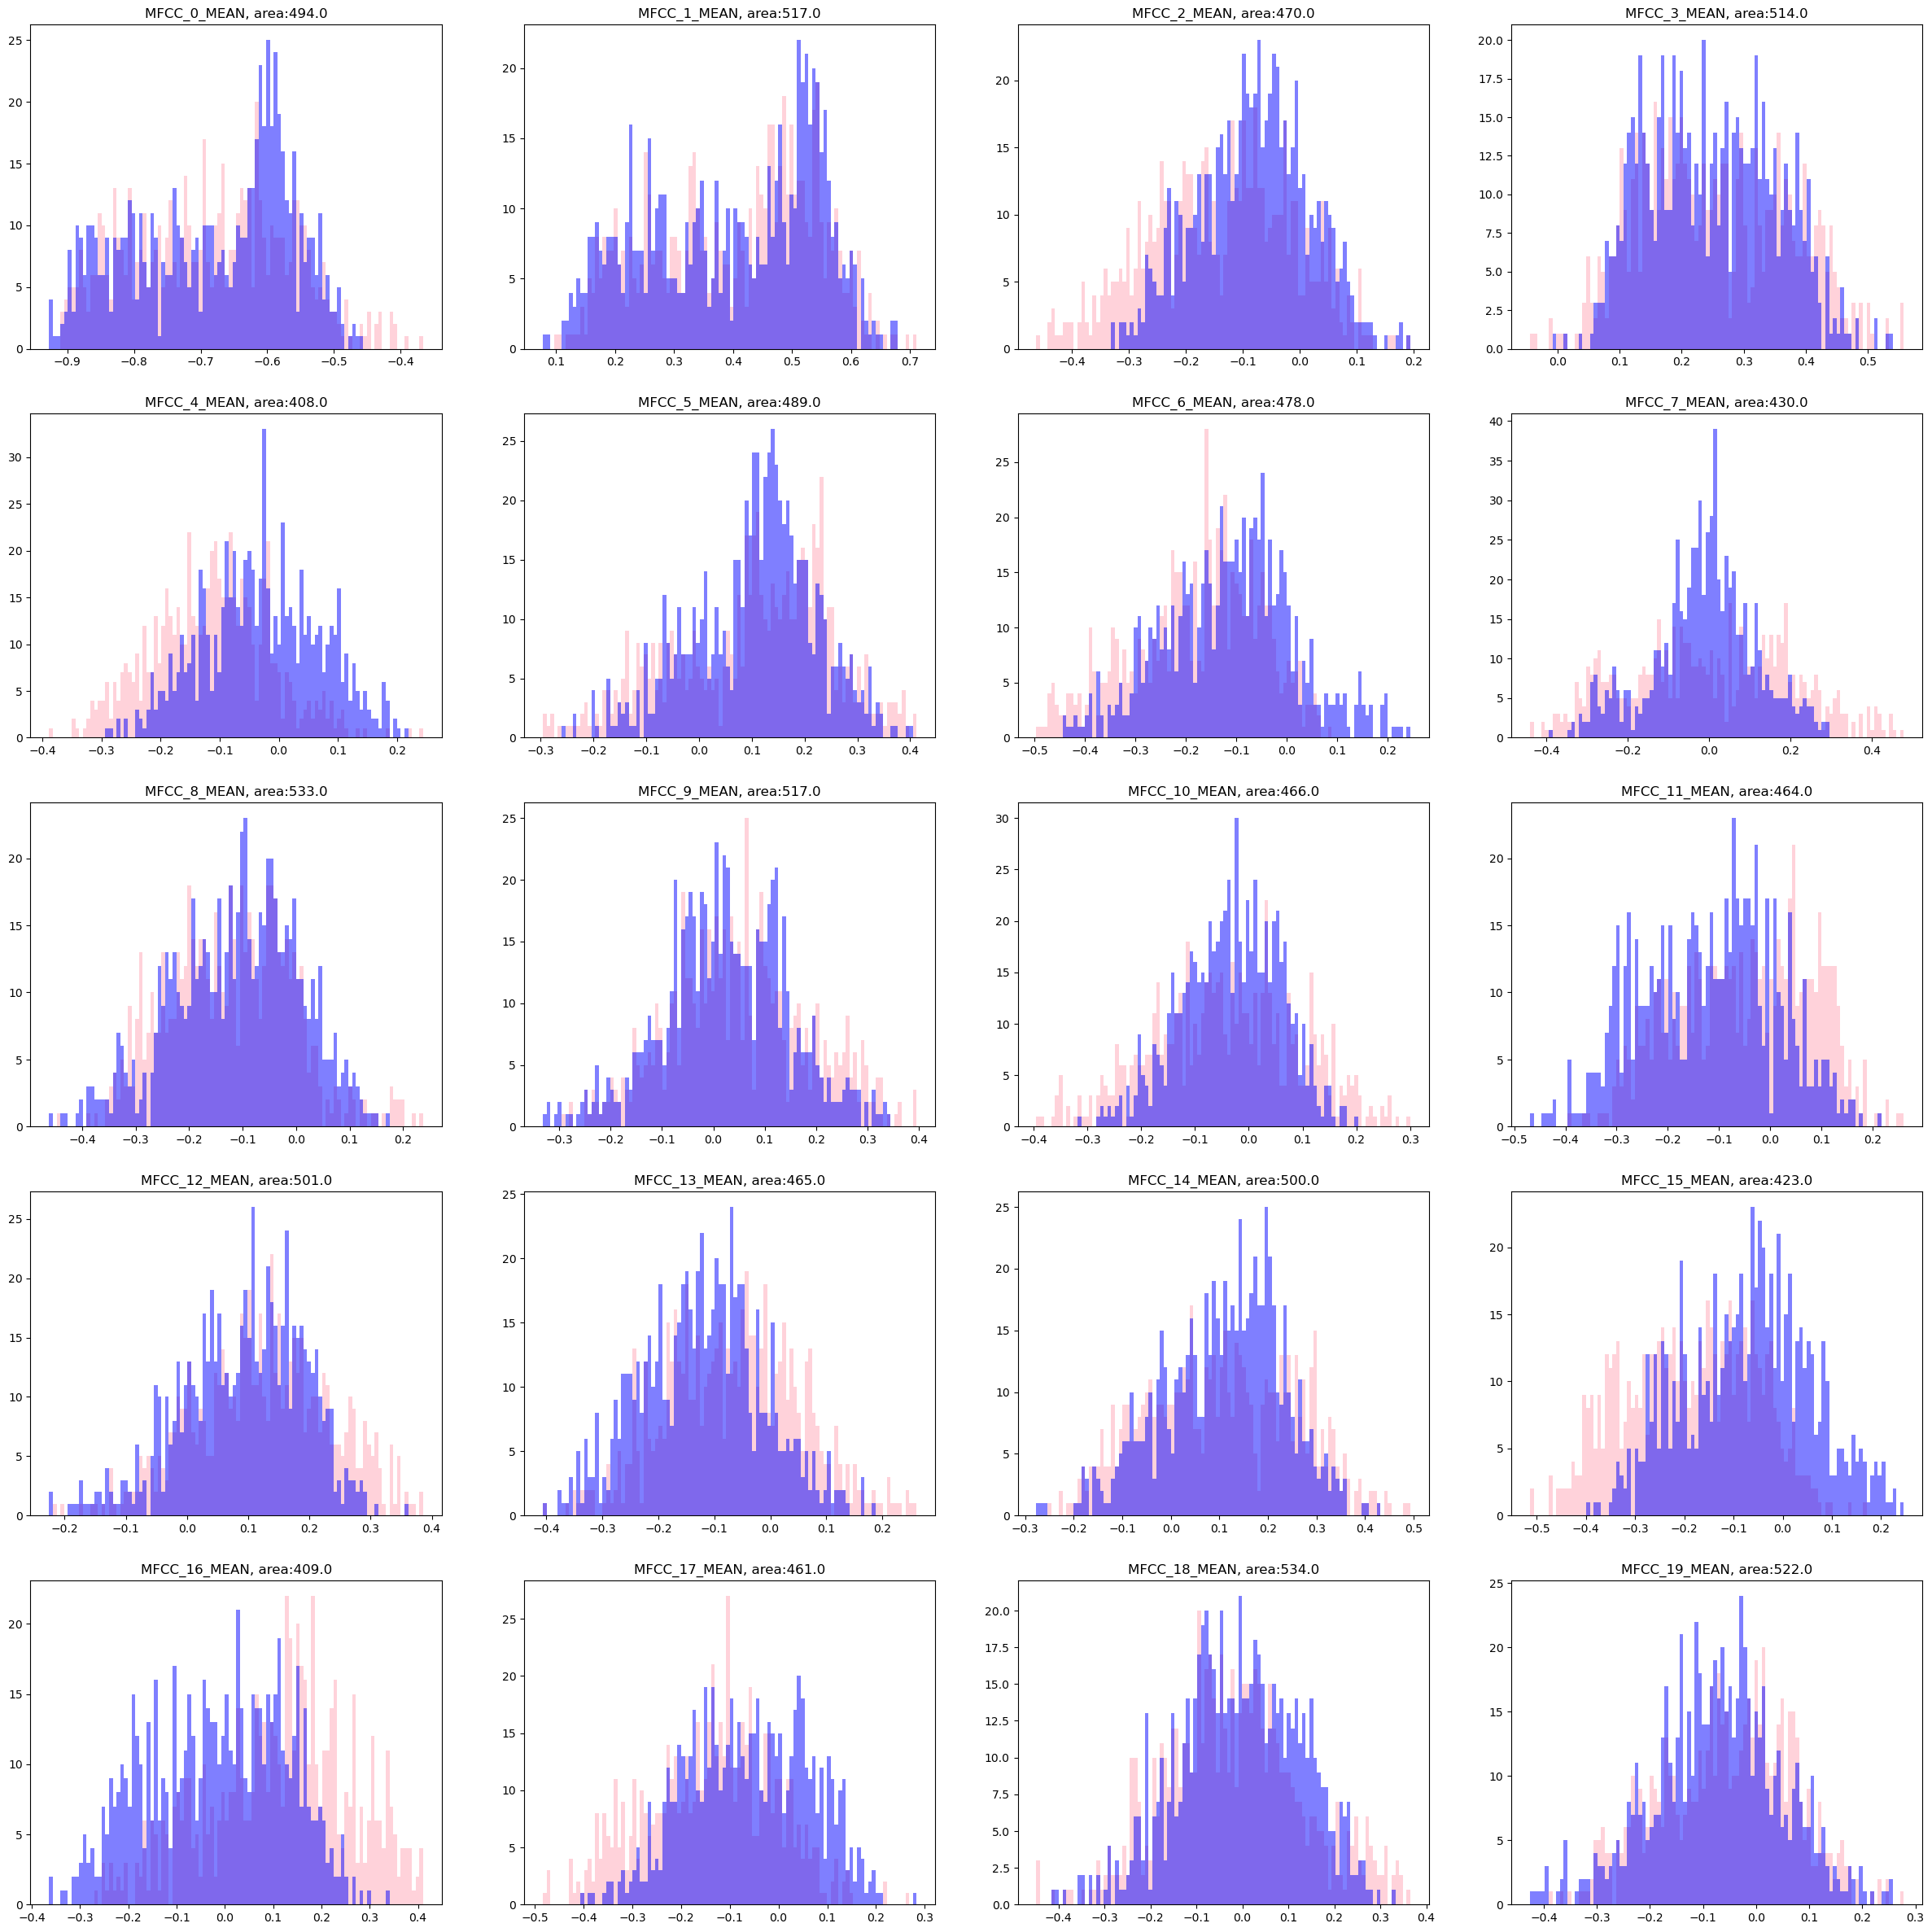

In [27]:
num_rows = 5
num_columns = 4
mfcc_index = 0
fig, axs = plt.subplots(num_rows, num_columns, figsize=(30, 30))
areas = []
for row in range(num_rows):
    for cls in range(num_columns):
        female_df = mfccs_df[(mfccs_df["SEX"]=="F")][f"MFCC_{mfcc_index}_MEAN"]
        male_df = mfccs_df[(mfccs_df["SEX"]=="M")][f"MFCC_{mfcc_index}_MEAN"]
        rng = min(female_df.min(), male_df.min()) , max(female_df.max() ,male_df.max())
        n1, bins1, _ = axs[row][cls].hist(mfccs_df[(mfccs_df["SEX"]=="F")][f"MFCC_{mfcc_index}_MEAN"] \
                                          , alpha=0.7, range= rng, bins = 100, color='pink')
        n2, bins2, _ = axs[row][cls].hist(mfccs_df[(mfccs_df["SEX"]=="M")][f"MFCC_{mfcc_index}_MEAN"] \
                                          , alpha=0.5, range= rng, bins = 100, color='blue')
        area = np.minimum(n1,n2).sum()
        axs[row][cls].set_title(f"MFCC_{mfcc_index}_MEAN, area:{area}")
        areas.append((mfcc_index, area))
        mfcc_index+=1

The result is a list with the follwing form: [(mean_id, area_id),(...),...] so i want to sort the list based on the second values. The criterium i used to decide which index consider "good" was: i take the mean of all the areas keep only the areas under that mean. This decision was driven by the fact that thresholding keeping only the first k would have required an analysis for each k. I was also interested in keeping only some of the total number of means, so a subset of the 20 mfccs.

In [28]:
area_mean = np.mean([area[1] for area in areas])
good_index = sorted([area[0] for area in areas if area[1] <= area_mean])
good_index

[2, 4, 6, 7, 10, 11, 13, 15, 16, 17]

I want to plot the graphs associated with the means for each mfcc value to check if the indexes i found before are reasonable or not. I expect that in correspondance to the indexes 2, 4, ... the mean graph is considerably more separated than the other. For example in the graph referred to the MFCC_2, if i draw a vertical line in correspondence of x=-0.1 i'm keeping a lot of orange points on the right and a lot of blue points on the left og the immaginary line i drawn.

In [29]:
def get_plot(df, col):
    num_rows = 5
    num_columns = 4
    mfcc_index = 0
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(30, 30))
    for row in range(num_rows):
        for cls in range(num_columns):
            sns.lineplot(y = range(len(df[f'MFCC_{mfcc_index}{col}'.strip()])),\
                         x=f'MFCC_{mfcc_index}{col}'.strip(), hue='SEX', data=df, marker='o',\
                         linestyle='', ax=axs[row][cls])
            mfcc_index+=1
    return fig

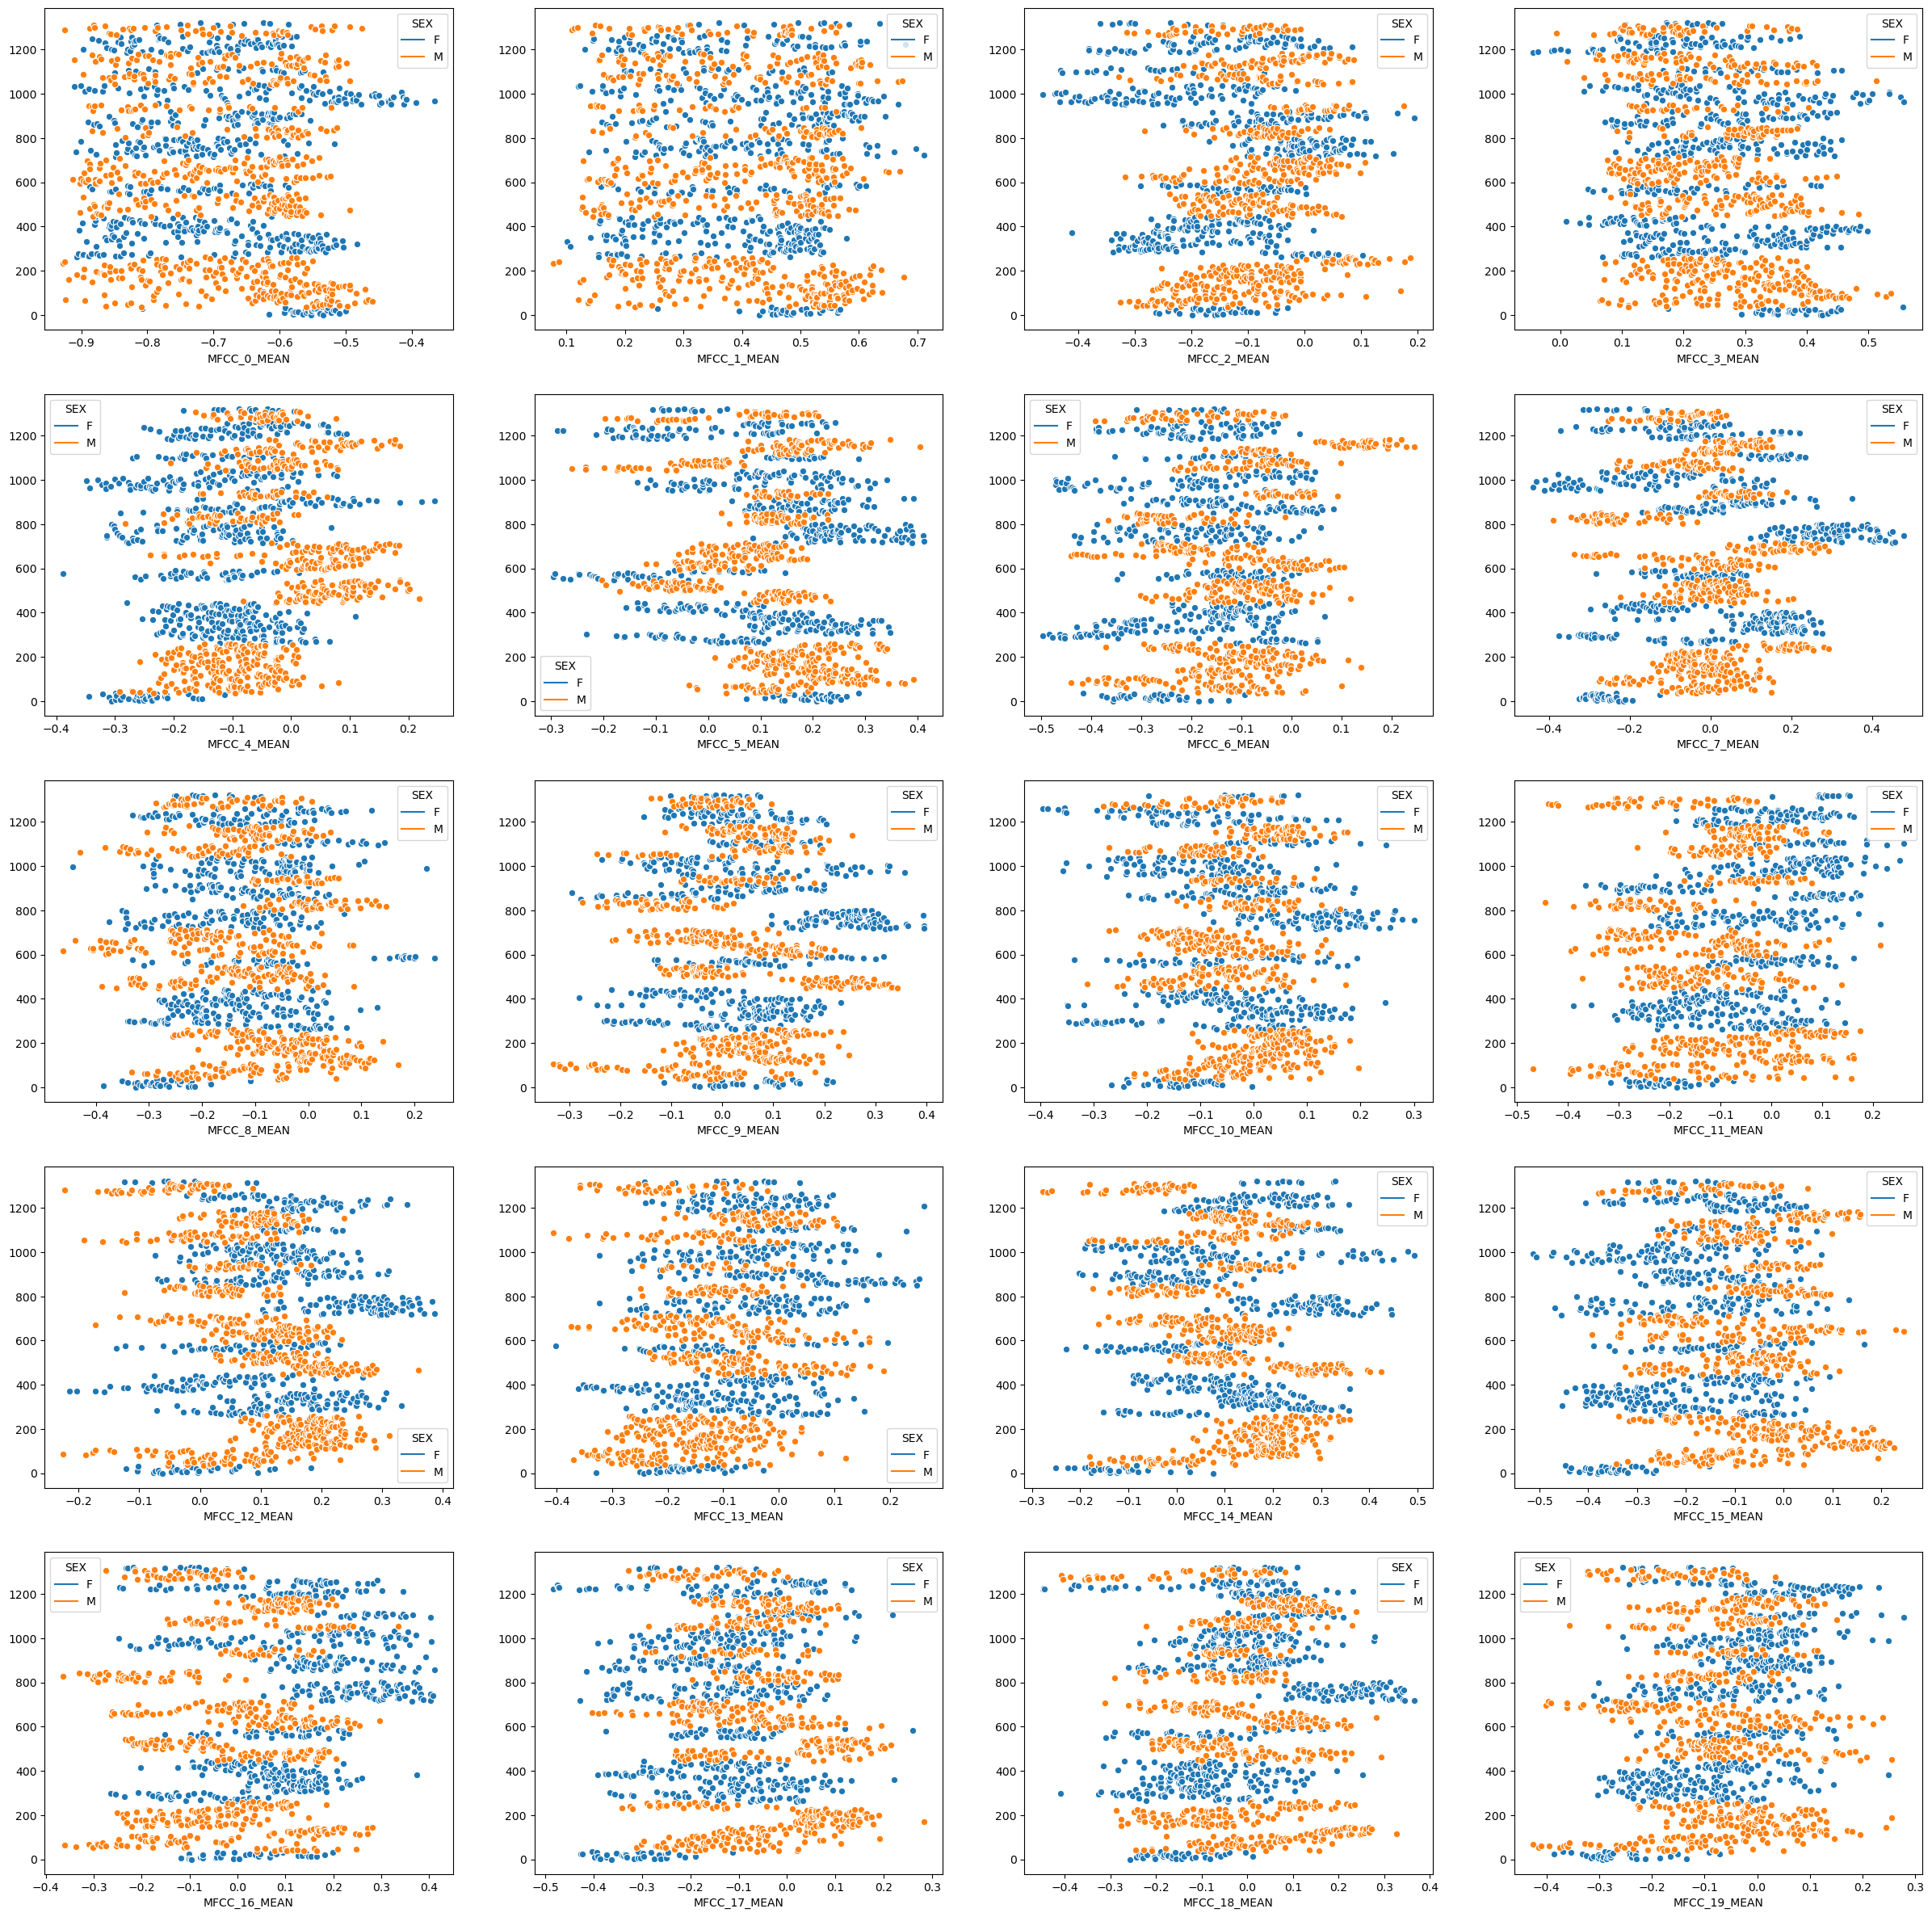

In [30]:
fig = get_plot(mfccs_df,'_MEAN')
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder

In [32]:
#i want the dataset with only the values for the most separable means
vls = [f"MFCC_{i}_MEAN" for i in good_index]
vls.append("SEX")

I decided to use 2 different "naive" classificators: a K-NN and a forest ensamble (more sophisticated than K-nn). I decided to use K-NN because in theory is tends to the best classifier (bayes optimal) but it's a known problem that this classifier suffers from the curse of dimensionality **but** in this case i only have 10 features which is totally feasible. I then choosed the forest ensamble becase each tree is capable of drawing separation plans boht perpendicular to x and to y, in this case i thougth that maybe more complex division plans were a good idea to try to separate the means. I choosed one esamble with the idea that each tree was focused on one particular means value and some other trees on features combinations.

In [33]:
#i will use more than one dataframe only make the code clearer.
mfcc_forest = mfccs_df[vls].copy()
mfcc_forest.head()

,MFCC_2_MEAN,MFCC_4_MEAN,MFCC_6_MEAN,MFCC_7_MEAN,MFCC_10_MEAN,MFCC_11_MEAN,MFCC_13_MEAN,MFCC_15_MEAN,MFCC_16_MEAN,MFCC_17_MEAN,SEX
0,-0.197814,-0.305996,-0.185799,-0.215327,-0.140691,-0.185966,-0.242757,-0.381600,-0.095538,-0.362465,F
1,-0.158695,-0.237850,-0.356127,-0.227942,-0.159731,-0.256824,-0.220504,-0.396755,-0.007960,-0.386457,F
2,-0.153966,-0.237502,-0.258003,-0.280749,-0.003707,-0.159107,-0.097230,-0.319321,0.002623,-0.275295,F
3,-0.143883,-0.251137,-0.124742,-0.248966,-0.150916,-0.170000,-0.220723,-0.266451,-0.101534,-0.260736,F
4,-0.173349,-0.259897,-0.160806,-0.193457,-0.244325,-0.230247,-0.329371,-0.342654,-0.098008,-0.316142,F


In [34]:
X = mfcc_forest.drop('SEX', axis=1)
y = mfcc_forest['SEX']

I wanted to check also for the numbers of male/female components in the prediction column, the distribution is quite even, but i preferred to use a random split with some stratification, i wanted to avoid the possibility that a lot of male examples were put in the traning set (or the opposite), and the same for the feamle examples.

In [35]:
y.value_counts()

M    695
F    629
Name: SEX, dtype: int64

In [36]:
random_stt = np.random.randint(1,1000)
print(random_stt)

420


I decided to use a classical 80,20 train test split, no particular resoning in this direction.

In [37]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_stt)

I decided to perform a randomized seach to find the best parameters for the depth and the number of tree in the ensamble. The range are empirically driven but the idea is to avoid to have very deep trees in order to avoid overfitting.

In [38]:
param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(1,40)}

rand_search = RandomizedSearchCV(RandomForestClassifier(), 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)
y_pred = rand_search.predict(X_test)

When i treat a general machine learning task, i'm always aware of the accuracy score due to it's computational-formula, in fact, if the number of true negative/positive one can find is very big then if we compute the rateo number of correct predictions/total number of predictions it will always be near 1. This is not the situation, in fact here we have an even number of elements in the dataset and it's not easy to determine the true negatives/positives. In this case the accuracy is pretty high, i also computed the confusion matrix from which it's easy to see that the number of false positive/negative for each class is even, in this case we can say that the classifier has both high precision and recall.

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9471698113207547


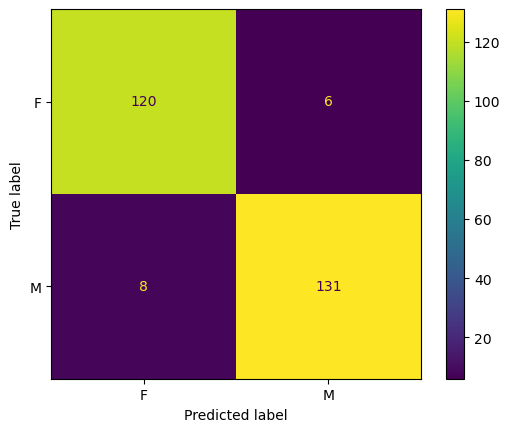

In [40]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y.values).tolist()).plot()

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           F       0.94      0.95      0.94       126
           M       0.96      0.94      0.95       139

    accuracy                           0.95       265
   macro avg       0.95      0.95      0.95       265
weighted avg       0.95      0.95      0.95       265



I also computed the mean of the score for a 5-CV score, which is not so good but neither so bad, this value means that we probably have some fluctuations while we change the set we test for so the classifier is not so stable:

In [42]:
scores = cross_val_score(rand_search, X, y, cv=5)
scores.mean()

0.7719325328759291

# KNN

I have done the same analysis with the KNN classifier. As i was suspecting the classifier computed with KNN is a little bit better: it's able to find less false positives/negatives than the previous one and in general is a little bit more robust than the forest ensamble.

In [44]:
parameters = {"n_neighbors": range(1, 50)}
gridsearchNN = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearchNN.fit(X_train, y_train)
y_pred = gridsearchNN.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9811320754716981


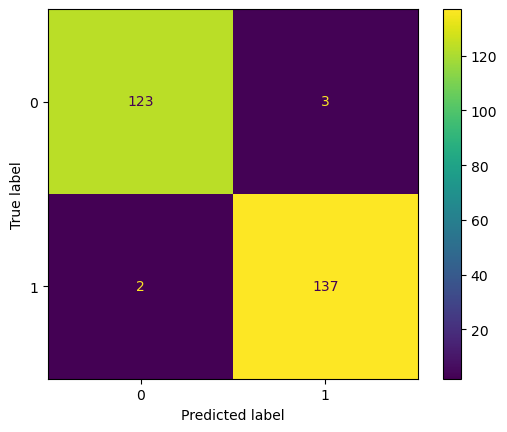

In [46]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           F       0.98      0.98      0.98       126
           M       0.98      0.99      0.98       139

    accuracy                           0.98       265
   macro avg       0.98      0.98      0.98       265
weighted avg       0.98      0.98      0.98       265



In [48]:
scores = cross_val_score(gridsearchNN, X, y, cv=5)
scores.mean()

0.7825014293882219

# NEURAL NETWORKS

In [50]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.random import set_seed
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives
from tensorflow import cast, float32, convert_to_tensor
from scikeras.wrappers import KerasClassifier

For the neural network session i decided to keep only the final network result and only describe the process i followed: for the "classical" neural network i started with the setting of a pretty big neural network (128 dense -> dropout(0.4) -> 64 -> dropout(0.2) -> 32 -> 16 -> 1) this first network was performing not so well (0.8 precision) so i suspected that the problem was about the structure (the parameters are very few, and they are pretty low) so i tried first of all to decreas a little the number of entering neurons, the idea was that we have a limited number of features and for this reason maybe using a big number of neurons may lead to lower precisions because all the informations were spread onto all the neurons, so i tried to decrese the input number to 64 -> deopout -> 32 -> dropout -> 16 -> 8 -> 1 and use a small dropout factor for both layers. The dropout for the layer was chose based on the fact that i wanted to dropout a small amount of informations (there are a small number of features, i didnt want to drop a lot of informations). This second network was performing a litlle bit better (0.85), for this reason i decided to keep the dropout rateos and just remove the 16-neurons layer, this decision was drove by the fact that having not so much parameters with a deep NN architecture may be not so good, removing the middle layer seemed to me a good choice. I used the RELU activation function for all the internal layers (a lot papers advise for that activation function) and a final sigmoid to have smoother outputs.

In [51]:
mfcc_nn = mfcc_forest.copy()

In [52]:
#one hot encode features
encoder = OneHotEncoder(dtype=np.int32)
mfcc_nn["SEX"] = encoder.fit_transform(mfcc_nn[["SEX"]]).toarray()

In [53]:
X = mfcc_nn.drop('SEX', axis=1)
y = mfcc_nn['SEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_stt)

In [54]:
def create_model():
    nn_model = Sequential([
        Dense(64, activation='relu', input_dim = X_train.shape[1]),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.005),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(loss=BinaryCrossentropy(),

                    optimizer=Adam(learning_rate=1e-3), 

                    metrics=['accuracy'])
    return nn_model

I decided to use also here a gridsearch for batch size and epochs.

In [55]:
model = KerasClassifier(model=create_model, verbose=False)
batch_size = [5, 15, 25, 50, 75, 150]
epochs = [50, 100, 150, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)
grid_result = grid.fit(X_train, y_train)

2023-03-24 16:53:29.799470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 16:53:29.799489: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 16:53:29.804980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 16:53:29.805001: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 16:53:29.966894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2023-03-24 16:59:22.949027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 16:59:22.949052: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 16:59:22.949070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattia): /proc/driver/nvidia/version does not exist
2023-03-24 16:59:22.949309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.966011 using {'batch_size': 5, 'epochs': 100}


In [57]:
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

0.964102 with: {'batch_size': 5, 'epochs': 50}
0.966011 with: {'batch_size': 5, 'epochs': 100}
0.959389 with: {'batch_size': 5, 'epochs': 150}
0.964111 with: {'batch_size': 5, 'epochs': 200}
0.954668 with: {'batch_size': 15, 'epochs': 50}
0.965054 with: {'batch_size': 15, 'epochs': 100}
0.955593 with: {'batch_size': 15, 'epochs': 150}
0.962224 with: {'batch_size': 15, 'epochs': 200}
0.956568 with: {'batch_size': 25, 'epochs': 50}
0.961281 with: {'batch_size': 25, 'epochs': 100}
0.961281 with: {'batch_size': 25, 'epochs': 150}
0.964111 with: {'batch_size': 25, 'epochs': 200}
0.942395 with: {'batch_size': 50, 'epochs': 50}
0.957489 with: {'batch_size': 50, 'epochs': 100}
0.965997 with: {'batch_size': 50, 'epochs': 150}
0.959380 with: {'batch_size': 50, 'epochs': 200}
0.945220 with: {'batch_size': 75, 'epochs': 50}
0.957498 with: {'batch_size': 75, 'epochs': 100}
0.961263 with: {'batch_size': 75, 'epochs': 150}
0.952772 with: {'batch_size': 75, 'epochs': 200}
0.920688 with: {'batch_size':

In [58]:
nn_model = create_model()
nn_model.fit(X_train, y_train, batch_size=grid_result.best_params_.get('batch_size'), epochs=grid_result.best_params_.get('epochs'), verbose=1)
nn_model.evaluate(X_test,y_test)

Epoch 1/100
212/212 [==============================] - 1s 1ms/step - loss: 0.5334 - accuracy: 0.8026
Epoch 2/100
212/212 [==============================] - 0s 1ms/step - loss: 0.3245 - accuracy: 0.8602
Epoch 3/100
212/212 [==============================] - 0s 1ms/step - loss: 0.2782 - accuracy: 0.8678
Epoch 4/100
212/212 [==============================] - 0s 1ms/step - loss: 0.2361 - accuracy: 0.8914
Epoch 5/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1986 - accuracy: 0.9103
Epoch 6/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1755 - accuracy: 0.9207
Epoch 7/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.9386
Epoch 8/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1418 - accuracy: 0.9339
Epoch 9/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1177 - accuracy: 0.9566
Epoch 10/100
212/212 [==============================] - 0s 1ms/step - loss: 0.1122 - accura

212/212 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9839
Epoch 82/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9877
Epoch 83/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 0.9991
Epoch 84/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9972
Epoch 85/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.9962
Epoch 86/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9962
Epoch 87/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9991
Epoch 88/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9991
Epoch 89/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 90/100
212/212 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 

[0.20713214576244354, 0.9584905505180359]

In [61]:
y_pred = nn_model.predict(X_test)
print(classification_report(y_test,(y_pred > 0.5).astype("int32")))

9/9 [==============================] - 0s 831us/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       139
           1       0.95      0.97      0.96       126

    accuracy                           0.96       265
   macro avg       0.96      0.96      0.96       265
weighted avg       0.96      0.96      0.96       265



Both accuracy and recall increased using a NN classification method

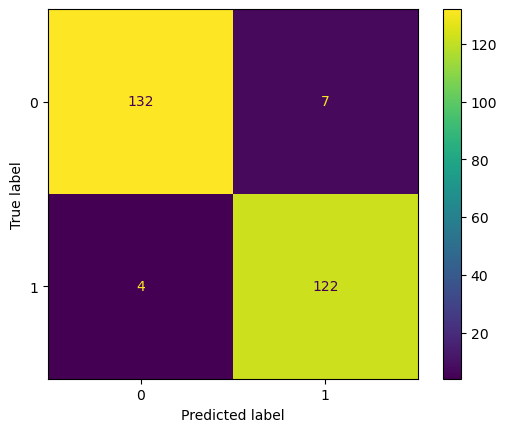

In [62]:
cm = confusion_matrix(y_test, (y_pred > 0.5).astype("int32"))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The CNN part was the thoughest one. I started redefining the dataframe from scratch, i decided to do so because i had to consider a new feature. In the following dataframe there will be only the sex and the the matrix composed by the valuable mfccs indexes. I have created a stratified partition as i had done before and i made some changes to the partitions to be able to give it as an input to tensorflow. I had to reshape all the features to pass them into the cnn. I then created a CNN and i set up some parameters as before.

# CNN

In [63]:
mfccs_values = []
for ids in speakers_df['ID']:
    audio_list = get_audio_files_path(ids)
    for audio in audio_list:
        y , sr = librosa.load(audio)
        y = librosa.util.fix_length(y, size=mean_time_duration, mode='edge')
        mfccs = librosa.util.normalize(librosa.feature.mfcc(y=y, sr=sr), axis=1)
        speaker_sex = speakers_df.loc[speakers_df['ID'] == ids, 'SEX'].iloc[0]
        base_series = [speaker_sex,mfccs[good_index]]
        mfccs_values.append(base_series)

In [64]:
mfccs_df_columns = ["SEX", "MFCC_COMPRESSED"]
mfccs_df_cnn = pd.DataFrame(mfccs_values, columns=mfccs_df_columns)
encoder = OneHotEncoder(dtype=np.float32)
mfccs_df_cnn["SEX"] = encoder.fit_transform(mfccs_df_cnn[["SEX"]]).toarray()
mfccs_df_cnn.head(5)

,SEX,MFCC_COMPRESSED
0,1.0,"[[0.27704757, 0.22916506, 0.21119052, 0.188869..."
1,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1.0,"[[0.053337447, 0.06491511, 0.21806397, 0.29262..."
4,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [66]:
X = mfccs_df_cnn.drop("SEX", axis = 1)
y = mfccs_df_cnn['SEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_stt)

In [67]:
X_train = np.stack(X_train.MFCC_COMPRESSED.values)
X_test = np.stack(X_test.MFCC_COMPRESSED.values)
X_train.shape, X_test.shape

((952, 10, 324), (409, 10, 324))

In [68]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_train.shape, y_test.shape

((952, 1), (409, 1))

I decided to follow some results i found in a previous research project:
<ol>
    <li> Increase the number of filters
    <li> Increase the dropout to avoid overfitting
    <li> Use relu functions on all layers, sigmoid on the last one for binary classification
<ol>
i didnt used the batchnormalizer because the bit i have in the matrixes are not RGB values, so normalizing is not the right choice in this framework.

In [160]:
def create_cnn_model():
    cnn_model = Sequential([
        Conv2D(filters=16,kernel_size=3,activation='relu'\
               ,input_shape = (X_train.shape[1],X_train.shape[2],1), data_format='channels_last'),
        MaxPooling2D(pool_size=2),
        Dropout(0.020),
        Conv2D(filters=25,kernel_size=3,activation='relu'),
        MaxPooling2D(pool_size=2) ,
        Dropout(0.025),
        Flatten(),
        Dense(64,activation='relu'),
        Dropout(0.025),
        Dense(32,activation='relu'),
        Dropout(0.030),
        Dense(8,activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    
    cnn_model.compile(loss =BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-3),metrics =['accuracy'])
    
    return cnn_model

I added an early stopper because the network achieve fast the 1 accuracy, so i early stop after some iterations i which the accuracy remains 1. I also checked for the numbers of paramter in the model because i wanted to see the number of inputs after the flatten layer and maybe to increase the number of neurons in the first dense layer (i did not incrased it because it leaded me to worst results). I know that there are not deterministic methods that one can use to have the best NN, i think it's a fine tune work and it have to be done carefully.

In [161]:
es = EarlyStopping(
    monitor='accuracy',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
)

In [162]:
cnn_model = create_cnn_model()
print(cnn_model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 8, 322, 16)        160       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 4, 161, 16)       0         
 g2D)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 4, 161, 16)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 2, 159, 25)        3625      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 1, 79, 25)        0         
 g2D)                                                            
                                                                 
 dropout_98 (Dropout)        (None, 1, 79, 25)       

In [163]:
cnn_model.fit(X_train, y_train, batch_size=5, epochs=50, verbose=1, callbacks=[es])
cnn_model.evaluate(X_test,y_test)

Epoch 1/50
191/191 [==============================] - 2s 6ms/step - loss: 0.6934 - accuracy: 0.5263
Epoch 2/50
191/191 [==============================] - 1s 7ms/step - loss: 0.5630 - accuracy: 0.6754
Epoch 3/50
191/191 [==============================] - 1s 7ms/step - loss: 0.2810 - accuracy: 0.8918
Epoch 4/50
191/191 [==============================] - 1s 7ms/step - loss: 0.1961 - accuracy: 0.9275
Epoch 5/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1481 - accuracy: 0.9433
Epoch 6/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0879 - accuracy: 0.9674
Epoch 7/50
191/191 [==============================] - 1s 7ms/step - loss: 0.0629 - accuracy: 0.9790
Epoch 8/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0380 - accuracy: 0.9863
Epoch 9/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0587 - accuracy: 0.9800
Epoch 10/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0206 - accuracy: 0.9916

[0.37726905941963196, 0.9339853525161743]

In [166]:
y_pred = cnn_model.predict(X_test)
print(classification_report(y_test,(y_pred > 0.5).astype("int32")))

13/13 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       210
         1.0       0.92      0.95      0.93       199

    accuracy                           0.93       409
   macro avg       0.93      0.93      0.93       409
weighted avg       0.93      0.93      0.93       409



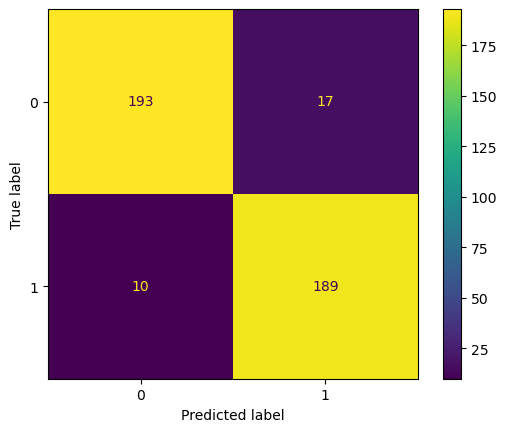

In [167]:
cm = confusion_matrix(y_test, (y_pred > 0.5).astype("int32"))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()